In [41]:
import pandas as pd

am_df = pd.read_csv("..\\data\\0001075-250213122211068.csv", sep='\t')
am_df = am_df[am_df['decimalLatitude'].notnull() & am_df['decimalLongitude'].notnull()]

all_df = pd.read_csv("..\\data\\0007450-250310093411724.csv", sep='\t')
all_df = all_df[all_df['decimalLatitude'].notnull() & all_df['decimalLongitude'].notnull()]

decades = {
    "1985_1994": (1985, 1994),
    "1995_2004": (1995, 2004),
    "2005_2014": (2005, 2014),
    "2015_2024": (2015, 2024)
}

quinquenniums = {
    "1990_1994": (1990, 1994),
    "1995_1999": (1995, 1999),
    "2000_2004": (2000, 2004),
    "2005_2009": (2005, 2009),
    "2010_2014": (2010, 2014),
    "2015_2019": (2015, 2019),
    "2020_2024": (2020, 2024)
}
# for some reason no amaranthus in 1985-1989

for name, (start, end) in quinquenniums.items():
    df_quin = am_df[(am_df["year"] >= start) & (am_df["year"] <= end)]
    df_quin.to_csv(f"..\\quinquenniums\\amaranthus_{name}.csv", sep='\t', index=False)

C:\Users\julia\AppData\Local\Temp\ipykernel_3116\442596275.py:6: DtypeWarning: Columns (23,24,25,46) have mixed types. Specify dtype option on import or set low_memory=False.
  all_df = pd.read_csv("..\\data\\0007450-250310093411724.csv", sep='\t')


In [53]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import numpy as np

def create_buffers(obs_df: pd.DataFrame, radius: float) -> gpd.GeoDataFrame:
    """
    Creates 1 km vector buffers around observation points. Assumes observations 
    from GBIF and has 'decimalLongitude' and 'decimalLatitude' keys
    
    Args:
        obs_df (pd.DataFrame): DataFrame containing GBIF observation coordinates 
                               with 'decimalLongitude' and 'decimalLatitude' columns.

    Returns:
        gpd.GeoDataFrame: A GeoDataFrame with original points and their corresponding 1 km buffers.
    """
    geometry = [Point(lon, lat) for lon, lat in zip(obs_df['decimalLongitude'], obs_df['decimalLatitude'])]
    gdf = gpd.GeoDataFrame(obs_df, geometry=geometry, crs="EPSG:4326")

    gdf_utm = gdf.to_crs("EPSG:32616")
    gdf_utm['buffers'] = gdf_utm.geometry.buffer(radius)
    return gdf_utm

buffers = {}


for quin in quinquenniums.keys():
    gbif_obs_file_path = f'..\\quinquenniums\\amaranthus_{quin}.csv'
    df = pd.read_csv(gbif_obs_file_path, sep='\t')

    buffers["am_"+quin] = create_buffers(df, radius=500)

for quin in quinquenniums.keys():
    gbif_obs_file_path = f'..\\quinquenniums\\all_{quin}.csv'
    df = pd.read_csv(gbif_obs_file_path, sep='\t')

    buffers["all_"+quin] = create_buffers(df, radius=500)

print(buffers.keys())


# gbif_observations_file_path = '..\\quinquenniums\\amaranthus_1985_1994.csv'
# df = pd.read_csv(gbif_observations_file_path, sep='\t')
# df_2010 = pd.read_csv('..\\data\\amaranthus_2005_2014.csv', sep='\t')
# df_2020 = pd.read_csv('..\\data\\amaranthus_2015_2024.csv', sep='\t')

# all_df_1990 = pd.read_csv('..\\data\\all_1985_1994.csv', sep = ',')
# all_df_2020 = pd.read_csv('..\\data\\all_2015_2024.csv', sep = ',')

# gdf_utm = create_buffers(df, radius=500)
# gdf_all_utm = create_buffers(all_df_1990, radius = 500)
# gdf_all_utm_2020 = create_buffers(all_df_2020, radius = 500)
# gdf_utm_2010 = create_buffers(df_2010, radius=500)
# gdf_utm_2020 = create_buffers(df_2020, radius=500)



dict_keys(['am_1990_1994', 'am_1995_1999', 'am_2000_2004', 'am_2005_2009', 'am_2010_2014', 'am_2015_2019', 'am_2020_2024', 'all_1990_1994', 'all_1995_1999', 'all_2000_2004', 'all_2005_2009', 'all_2010_2014', 'all_2015_2019', 'all_2020_2024'])


In [2]:
# extract_dir = "..\us_il_shapefiles"
# zip_file_path = os.path.join(extract_dir, "IL_BNDY_State.zip")

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)

# shapefile_path = os.path.join(extract_dir, "IL_BNDY_State_Ln.shp")
# il_gdf = gpd.read_file(shapefile_path)

#for more precise illinois state boundaries--didn't end up using
import geopandas as gpd
from shapely.geometry import Point, Polygon

il_coordinates = [
    (-87.5292755, 41.7567867),(-87.65849562959642, 42.07535913962207),(-87.8202036456503, 42.29139449472285),(-87.80023830534141, 42.39062280521323),
    (-87.79487855575071, 42.49185408277431),(-90.64281757866335, 42.50852726394397),(-90.65551555943709, 42.47936856524973),(-91.3602079772792, 39.78736513631642),
    (-90.1854151112902, 38.82668498499032),(-90.18548064080385, 38.59781705568738),(-90.36966801607325, 38.23430194721997),(-89.24896546412347, 37.01952178474121),(-88.46974294326039, 37.0584455654243),
    (-87.56754675242111, 38.606499187711364),(-87.53189667394427, 39.35454637993529)
]

il_polygon = Polygon(il_coordinates)
gdf_il = gpd.GeoDataFrame({'geometry': [il_polygon]}, crs="EPSG:4326")

In [45]:
import rasterio
from rasterio.crs import CRS

# define custom CRS
nlcd_custom_wkt = """
PROJCS["AEA        WGS84",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Albers_Conic_Equal_Area"],
    PARAMETER["latitude_of_center",23],
    PARAMETER["longitude_of_center",-96],
    PARAMETER["standard_parallel_1",29.5],
    PARAMETER["standard_parallel_2",45.5],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],AXIS["Northing",NORTH]]
"""
custom_crs = rasterio.crs.CRS.from_wkt(nlcd_custom_wkt)
# gdf_aea = gdf_utm.to_crs(custom_crs)
# gdf_all_aea = gdf_all_utm.to_crs(custom_crs)
# gdf_all_aea_2020 = gdf_all_utm_2020.to_crs(custom_crs)
#gdf_controls_aea = gdf_controls.to_crs(custom_crs)
print(gdf_il.crs)
gdf_il = gdf_il.to_crs(custom_crs)

# gdf_aea['buffers'] = gdf_aea['buffers'].to_crs(custom_crs)
# gdf_aea_2010 = gdf_utm_2010.to_crs(custom_crs)
# gdf_aea_2020 = gdf_utm_2020.to_crs(custom_crs)
# gdf_aea_2010['buffers'] = gdf_aea_2010['buffers'].to_crs(custom_crs)
# gdf_aea_2020['buffers'] = gdf_aea_2020['buffers'].to_crs(custom_crs)

# gdf_all_aea['buffers'] = gdf_all_aea['buffers'].to_crs(custom_crs)
# gdf_all_aea_2020['buffers'] = gdf_all_aea_2020['buffers'].to_crs(custom_crs)

for gdf in buffers:
    buffers[gdf] = buffers[gdf].to_crs(custom_crs)
    buffers[gdf]['buffers'] = buffers[gdf]['buffers'].to_crs(custom_crs)

print(gdf_il.crs)
print(buffers['all_1990_1994']['buffers'].crs)
print(gdf_il.head())

PROJCS["AEA        WGS84",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
PROJCS["AEA        WGS84",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAM

In [19]:
print(buffers['all_1990_1994']['buffers'].crs)


PROJCS["AEA        WGS84",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [46]:
nlcd_classes = {
    11: "Water",
    12: "Perennial Ice/Snow",
    21: "Developed, Open Space",
    22: "Developed, Low Intensity",
    23: "Developed, Medium Intensity",
    24: "Developed, High Intensity",
    31: "Barren Land",
    41: "Deciduous Forest",
    42: "Evergreen Forest",
    43: "Mixed Forest",
    52: "Shrub/Scrub",
    71: "Grassland/Herbaceous",
    81: "Pasture/Hay",
    82: "Cultivated Crops",
    90: "Woody Wetlands",
    95: "Emergent Herbaceous Wetlands"
}

In [47]:
from rasterstats import zonal_stats
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))

from diversity_indices import calculate_shannon_index

def nlcd_zonal_stats(geometry: gpd.GeoSeries | gpd.GeoDataFrame, nlcd_file_path) -> list[dict[str, float | str]]:
    """
    Computes land cover class proportions within given geometries using NLCD raster data.

    Args:
        geometry (gpd.GeoSeries | gpd.GeoDataFrame): Geospatial data representing areas of interest.

    Returns:
        list[dict[str, float | str]]: A list of dictionaries containing land cover class proportions 
                                      and Shannon diversity index for each geometry.
    """
   
    result = []

    # uses the vector buffers as overlays and calculates the proportion of each
    # class in the raster National Land Cover data
    stats = zonal_stats(
        geometry, 
        nlcd_file_path, 
        categorical=True,
        category_map=nlcd_classes,
        geojson_out=True,
        all_touched = True
    )
    for zone in stats:
        props = zone['properties'] # dictionary corresponding to number of pixels per class
        total = sum(props.values())  # total pixels in buffer
        percentages = {k: (v / total) * 100 for k, v in props.items() if k != 'id'}
        
        proportions = np.array(list(percentages.values()))
        shannon_index = calculate_shannon_index(proportions)
        percentages['shannon_index'] = shannon_index
        result.append(percentages)

    return result

In [54]:
print(len(buffers['am_1990_1994']))

66


In [61]:
ALPHA = 0.05          # 95 % CI
Z      = 1.96

def _summarise_lu(df: pd.DataFrame) -> pd.DataFrame:
    """
    df: rows = buffers, cols = 13 land‑use classes (numeric 0–100)
    Returns a tidy table with one row per class and summary stats as columns.
    """
    # basic stats
    stats = df.agg(
        ['mean', 'std',
         lambda x: x.quantile(0.25),
         'median',
         lambda x: x.quantile(0.75)]
    ).T

    stats.columns = ['mean', 'sd', 'q25', 'median', 'q75']
    stats['n']    = len(df)
    stats['se']   = stats['sd'] / np.sqrt(stats['n'])
    stats['ci_lo'] = stats['mean'] - Z * stats['se']
    stats['ci_hi'] = stats['mean'] + Z * stats['se']
    stats.index.name = 'lu_class'    # keep class code / name in a column later
    return stats.reset_index()


def mean_clean_df(input_results: list[dict[str, float|str]]) -> tuple[pd.DataFrame, float]:
    """
    Cleans dataframes and computes the mean proportions of land cover classes and the mean Shannon index.

    Args:
        input_results (list[dict[str, float | str]]): List of dictionaries with land cover proportions 
                                                      and Shannon diversity index.

    Returns:
        pd.Series: Mean proportions of each land cover class.
        float: Mean Shannon diversity index.
    """
    df = pd.DataFrame(input_results).fillna(0)

    df = df.drop(columns=['id'], errors='ignore')
    df = df.apply(pd.to_numeric, errors='coerce')

    mean_shannon = df['shannon_index'].mean()
    df = df.drop(columns=['shannon_index'])

    df = df.sort_index(axis=1)

    summary_df = _summarise_lu(df)
    return summary_df, mean_shannon

def out_df(geometry: gpd.GeoSeries | gpd.GeoDataFrame, nlcd_file_path: str) -> pd.DataFrame:
    """
    Generates a DataFrame of land cover class proportions and computes the mean Shannon index.

    Args:
        geometry (gpd.GeoSeries | gpd.GeoDataFrame): Geospatial data to analyze.

    Returns:
        pd.DataFrame: DataFrame containing land cover class names and their average proportions.
        float: Mean Shannon diversity index across all geometries.
    """
def out_df(geometry, nlcd_file_path):
    vector = geometry.to_crs(custom_crs)
    result = nlcd_zonal_stats(vector, nlcd_file_path)

    summary_df, mean_shannon = mean_clean_df(result)
    return summary_df, mean_shannon

results = {}
for lu_type in ["am_", "all_"]:
    for quin in quinquenniums:
        year = int(quin.split("_")[0])+2 #take middle of 5 years
        results[lu_type+quin] = out_df(buffers[lu_type+quin]['buffers'], f"..\\nlcd_data\\Annual_NLCD_LndCov_{str(year)}_CU_C1V0.tif")

for quin in quinquenniums:
    year = int(quin.split("_")[0]) + 2
    results["il_"+quin] = out_df(gdf_il, f"..\\nlcd_data\\Annual_NLCD_LndCov_{str(year)}_CU_C1V0.tif")


    
#results_df, waterhemp_shannon_idx = out_df(gdf_aea['buffers'], "..\\nlcd_data\\Annual_NLCD_LndCov_2023_CU_C1V0.tif")
#control_results_df, control_shannon_idx = out_df(gdf_controls['buffers'], "..\\nlcd_data\\Annual_NLCD_LndCov_2023_CU_C1V0.tif")
#il_results_1995_df, _ = out_df(gdf_il, "..\\nlcd_data\\Annual_NLCD_LndCov_1995_CU_C1V0.tif")
#il_results_2005_df, _ = out_df(gdf_il, "..\\nlcd_data\\Annual_NLCD_LndCov_2005_CU_C1V0.tif")
#il_results_2015_df, _ = out_df(gdf_il, "..\\nlcd_data\\Annual_NLCD_LndCov_2015_CU_C1V0.tif")
#il_results_2020_df, _ = out_df(gdf_il, "..\\nlcd_data\\Annual_NLCD_LndCov_2020_CU_C1V0.tif")

# all_results_1985_1994, _ = out_df(gdf_all_aea['buffers'], "..\\nlcd_data\\Annual_NLCD_LndCov_2000_CU_C1V0.tif")
# all_results_2015_2023, _ = out_df(gdf_all_aea_2020['buffers'], "..\\nlcd_data\\Annual_NLCD_LndCov_2010_CU_C1V0.tif")

# all_results_2015_2023.to_csv("all_2015_2023_results.csv", index=False)
# all_results_1985_1994.to_csv("all_1985_1994_results.csv", index=False)

# amaranthus_results_1985_1994, _ = out_df(gdf_aea['buffers'], "..\\nlcd_data\\Annual_NLCD_LndCov_2000_CU_C1V0.tif")
# amaranthus_results_2005_2014, _ = out_df(gdf_aea_2010['buffers'], "..\\nlcd_data\\Annual_NLCD_LndCov_2000_CU_C1V0.tif")
# amaranthus_results_2015_2023, _ = out_df(gdf_aea_2020['buffers'], "..\\nlcd_data\\Annual_NLCD_LndCov_2000_CU_C1V0.tif")
# amaranthus_results_2005_2014.to_csv("amaranthus_2005_2014_results.csv", index=False)
# amaranthus_results_2015_2023.to_csv("amaranthus_2015_2023_results.csv", index=False)
# amaranthus_results_1985_1994.to_csv("amaranthus_1985_1994_results.csv", index=False)

#first_5000_rows = gdf_aea['buffers'].head(5000)
#all_plants_df, all_plants_shannon_idx = out_df(gdf_aea['buffers'], "..\\nlcd_data\\Annual_NLCD_LndCov_1990_CU_C1V0.tif")
#print(results_df)
#print(f"Shannon diversity index of land within 1000m of waterhemp occurences: {waterhemp_shannon_idx},\n\
#Control Shannon diversity index: {control_shannon_idx}")

#all_plants_df.to_csv("..\\amaranthus_1985_1994_results.csv", index=False)

#results_df.to_csv("..\\amaranthus_results.csv", index=False)
#control_results_df.to_csv("..\\control_results.csv", index=False)
#il_results_1995_df.to_csv("..\\il_results_1995.csv", index=False)
#il_results_2005_df.to_csv("..\\il_results_2005.csv", index=False)
#il_results_2015_df.to_csv("..\\il_results_2015.csv", index=False)
#il_results_2020_df.to_csv("..\\il_results_2020.csv", index=False)


In [62]:
for result in results:
    results[result][0].to_csv(f"..\\quin_results\\{result}.csv")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

Z = 1.96                          # 95 % normal quantile

am_path   = Path('..') / 'amaranthus_1985_1994_results.csv'
all_path  = Path('..') / 'all_1985_1994_results.csv'
il_path   = Path('..') / 'il_results_1990.csv' 

am   = pd.read_csv(am_path)
allp = pd.read_csv(all_path)
state = pd.read_csv(il_path)

if 'proportions' in state.columns:
    state = state.rename(columns={'proportions': 'mean'})
    # fabricate stub columns with NaN so we can treat it like a summary table
    for col in ['sd','q25','median','q75','n','se','ci_lo','ci_hi']:
        state[col] = np.nan

# merge on lu_class to guarantee identical ordering
merged = (am.merge(allp, on='lu_class', suffixes=('_am', '_all'))
            .merge(state, on='lu_class', suffixes=('', '_state')))

classes = merged['lu_class']
x = np.arange(len(classes))
width = 0.25

fig, ax_bar = plt.subplots(figsize=(12, 6))

ax_bar.bar(x - width, merged['mean_am' ], width,
           yerr=merged['se_am' ], capsize=3, label='Amaranthus')
ax_bar.bar(x, merged['mean_all'], width,
           yerr=merged['se_all'], capsize=3, label='All plants')
ax_bar.bar(x + width, merged['mean'], width,
           yerr=merged['se'], capsize=3, label='Illinois state')

ax_bar.set_ylabel('Mean proportion in 500 m buffer (%)')
ax_bar.set_title('Land Cover Class Proportion Within a 500m Radius(1985-1994)')
ax_bar.set_xticks(x)
ax_bar.set_xticklabels(classes, rotation=45, ha='right')
ax_bar.legend()

plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '..\\il_results_1990.csv'

In [ ]:
import pandas as pd
from pathlib import Path

#decades = ["1985_1994", "1995_2004", "2005_2014", "2015_2023"]
groups   = ["am", "all", "il"]

def load_one(path: str, group: str, quin: str) -> pd.DataFrame:
    df = pd.read_csv(path, header=0) # first row are column names
    df.columns = df.columns.str.strip()

    return (
        df.assign(group=group, quin=quin)
          .loc[:, ["quin", "group", "lu_class", "mean", "n", "se"]]
    )

records = [
    load_one(f"..\\quin_results\\{g}_{d}.csv", g, d)
    for d in quinquenniums.keys()
    for g in groups
]


tidy = pd.concat(records, ignore_index=True)

wide = (
    tidy
    .pivot_table(index=["quin", "lu_class"], columns="group", values="mean")
    .reset_index()
)

wide["EF_All_vs_IL"] = wide["all"] / wide["il"]
wide["EF_Am_vs_All"] = wide["am"]  / wide["all"]
wide["EF_Am_vs_IL"] = wide["am"]  / wide["il"]

wide["log2_EF_All_vs_IL"] = np.log2(wide["EF_All_vs_IL"])
wide["log2_EF_Am_vs_All"] = np.log2(wide["EF_Am_vs_All"])
wide["log2_EF_Am_vs_IL"] = np.log2(wide["EF_Am_vs_IL"])

keep = [
    "Cultivated Crops", "Deciduous Forest",
    "Developed, Medium Intensity", "Developed, Low Intensity", "Water", "Woody Wetlands", "Developed, High Intensity", "Developed, Open Space"
]

wide_plot = wide[wide["lu_class"].isin(keep)]


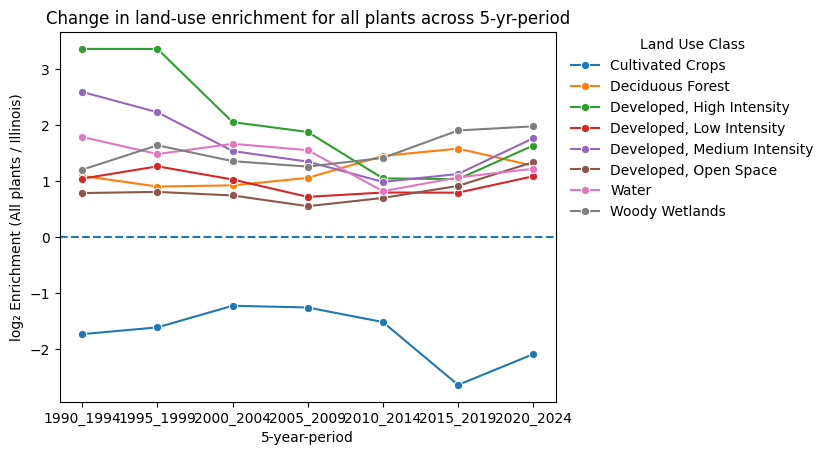

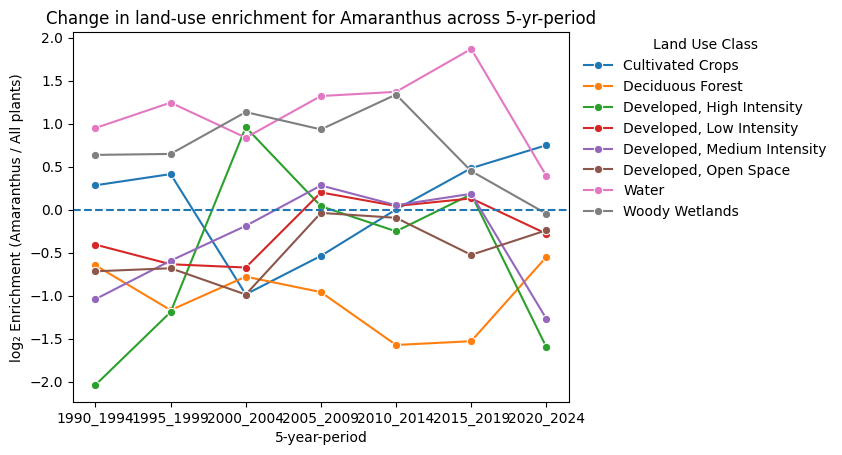

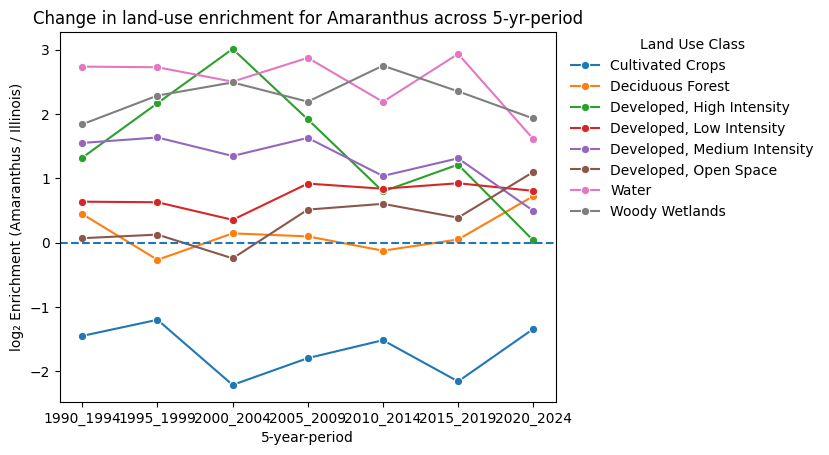

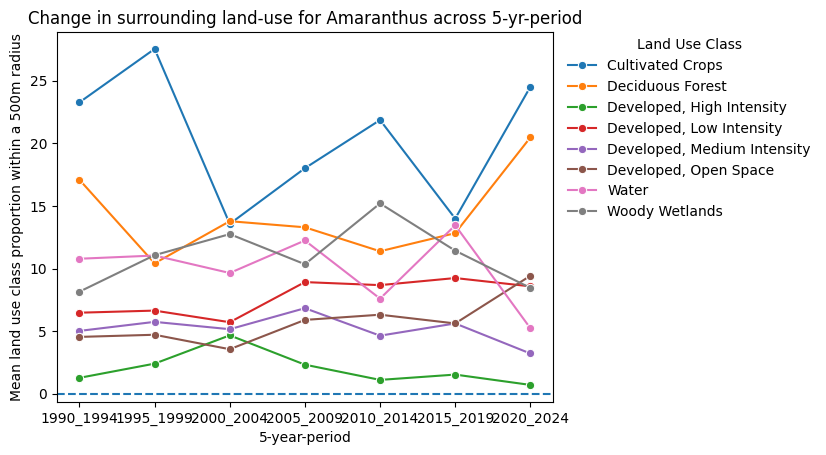

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns  # only for styling; omit if you wish

# all plants vs Illinois
fig1, ax1 = plt.subplots()
sns.lineplot(
    data=wide_plot,
    x="quin", y="log2_EF_All_vs_IL",
    hue="lu_class", marker="o", ax=ax1
)
ax1.axhline(0, ls="--") 
ax1.set_ylabel("log₂ Enrichment (All plants / Illinois)")
ax1.set_title("Change in land‑use enrichment for all plants across 5-yr-periods")

ax1.legend(
    title="Land Use Class",
    bbox_to_anchor=(1.02, 1),  # x‑offset, y‑offset
    loc="upper left",
    borderaxespad=0,
    frameon=False
)

# amaranthus vs all plants
fig2, ax2 = plt.subplots()
sns.lineplot(
    data=wide_plot,
    x="quin", y="log2_EF_Am_vs_All",
    hue="lu_class", marker="o", ax=ax2
)

ax2.axhline(0, ls="--")
ax2.set_ylabel("log₂ Enrichment (Amaranthus / All plants)")
ax2.set_title("Change in land‑use enrichment for Amaranthus across 5-yr-periods")
ax2.legend(
    title="Land Use Class",
    bbox_to_anchor=(1.02, 1),  # x‑offset, y‑offset
    loc="upper left",
    borderaxespad=0,
    frameon=False
)

fig3, ax3 = plt.subplots()
sns.lineplot(
    data=wide_plot,
    x="quin", y="log2_EF_Am_vs_IL",
    hue="lu_class", marker="o", ax=ax3
)

ax3.axhline(0, ls="--")
ax3.set_ylabel("log₂ Enrichment (Amaranthus / Illinois)")
ax3.set_title("Change in land‑use enrichment for Amaranthus across 5-yr-periods")
ax3.legend(
    title="Land Use Class",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0,
    frameon=False
)
ax1.set_xlabel("5-year-period")
ax2.set_xlabel("5-year-period")
ax3.set_xlabel("5-year-period")

fig4, ax4 = plt.subplots()
sns.lineplot(
    data=wide_plot,
    x="quin", y="am",
    hue="lu_class", marker="o", ax=ax4
)
ax4.axhline(0, ls="--")
ax4.set_ylabel("Mean land use class proportion within a 500m radius")
ax4.set_title("Change in surrounding land‑use for Amaranthus across 5-yr-periods")
ax4.legend(
    title="Land Use Class",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0,
    frameon=False
)

ax1.set_xlabel("5-year-period")
ax2.set_xlabel("5-year-period")
ax3.set_xlabel("5-year-period")
ax4.set_xlabel("5-year-period")

plt.show()

In [ ]:
il_path = '..\\il_results_1990.csv'
il_results_df = pd.read_csv(il_path) 
amaranthus_path = '..\\amaranthus_1985_1994_results.csv'
amaranthus_results_df = pd.read_csv(amaranthus_path)
all_plants_df = pd.read_csv('..\\all_1985_1994_results.csv')
merged_df = amaranthus_results_df.merge(all_plants_df, on='lu_class', suffixes=('_amaranthus', '_all_plants')).merge(il_results_df, on='lu_class')
merged_df.rename(columns={'proportions': 'proportions_illinois'}, inplace=True)

merged_df.head()

,lu_class,proportions_amaranthus,proportions_all_plants,proportions_illinois
0,Barren Land,0.211284,0.082135,0.189277
1,Cultivated Crops,18.903040,6.888540,62.063201
2,Deciduous Forest,25.330280,19.452956,12.419134
3,"Developed, High Intensity",5.717985,19.189398,0.688122
4,"Developed, Low Intensity",9.999283,9.725567,4.930395


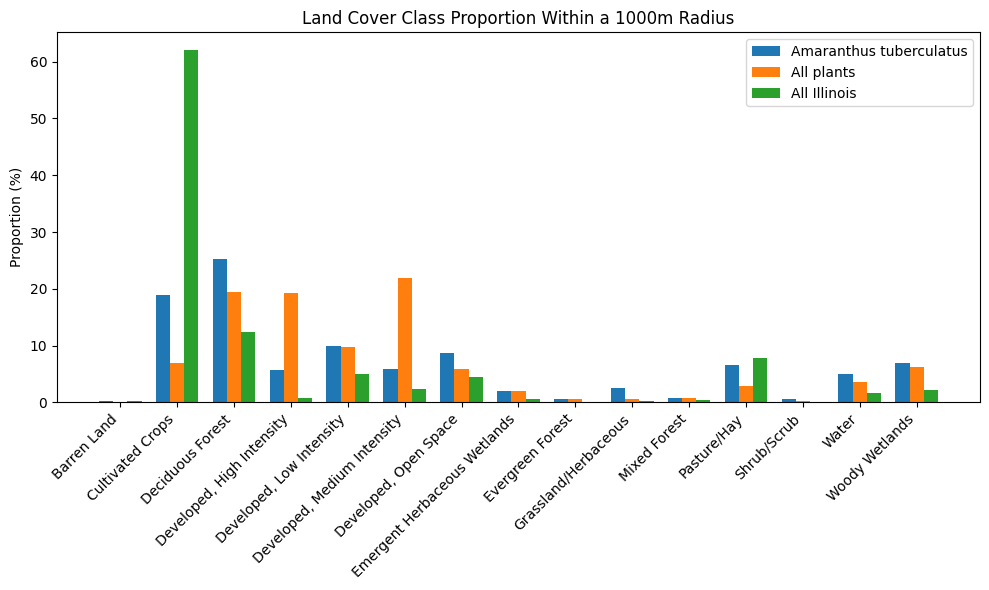

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(len(merged_df['lu_class']))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, merged_df['proportions_amaranthus'], width, label='Amaranthus tuberculatus')
ax.bar(x, merged_df['proportions_all_plants'], width, label='All plants')
ax.bar(x + width, merged_df['proportions_illinois'], width, label='All Illinois')
ax.set_xticks(x)
ax.set_xticklabels(merged_df['lu_class'], rotation=45, ha='right')
ax.set_ylabel('Proportion (%)')
ax.set_title('Land Cover Class Proportion Within a 1000m Radius')
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
# entire workflow for gbif_data
import numpy as np
def add_observation_land_use_data():
    df = pd.read_csv('..\\data\\0001075-250213122211068.csv', delimiter='	')
    filtered_df = df.dropna(subset=['decimalLongitude', 'decimalLatitude'])
    filtered_df = filtered_df[filtered_df["year"] < 2024]

    gdf = create_buffers(filtered_df, radius=300)
    gdf = gdf.to_crs(custom_crs)
    gdf['buffers'] = gdf['buffers'].to_crs(custom_crs)


    new_columns = ["land_cover_class", "top_class_300m", "proportion_agricultural_300m", "shannon_idx_300m"]
    for col in new_columns:
        filtered_df[col] = None

    for idx, row in gdf.iterrows():
        raster_path = f"..\\nlcd_data\\Annual_NLCD_LndCov_{row['year']}_CU_C1V0.tif"
        point = row.geometry
        with rasterio.open(raster_path) as src:
            coord = [(point.x, point.y)]
            pixel_value = next(src.sample(coord))[0]
            filtered_df.at[idx, 'land_cover_class'] = str(nlcd_classes.get(pixel_value, None))

    year_groups = gdf.groupby('year')
    for year, group in year_groups:
        raster_path = f"..\\nlcd_data\\Annual_NLCD_LndCov_{year}_CU_C1V0.tif"

        buffer_gdf = gpd.GeoDataFrame(
            {'geometry': group['buffers'].values}, index=group.index, crs=custom_crs)
        buffer_gdf = buffer_gdf.to_crs(custom_crs)

        proportions = nlcd_zonal_stats(buffer_gdf, raster_path)
        
        for i, (idx, _) in enumerate(group.iterrows()):
            if i < len(proportions) and proportions[i]:
                prop_dict = proportions[i]

                if len(prop_dict) > 1:
                    land_classes = {k: v for k, v in prop_dict.items() if k != 'shannon_index'}
                    top_class = max(land_classes.items(), key=lambda x: x[1], default=(None, 0))[0]
                    filtered_df.at[idx, 'top_class_300m'] = str(top_class)
                    
                    agricultural_classes = ['Cultivated Crops', 'Pasture/Hay']
                    agricultural_prop = sum(prop_dict.get(cls, 0) for cls in agricultural_classes)
                    filtered_df.at[idx, 'proportion_agricultural_300m'] = agricultural_prop
                
                # Get shannon index
                filtered_df.at[idx, 'shannon_idx_300m'] = prop_dict.get('shannon_index', 0)
    
            # row_gdf = gpd.GeoDataFrame([row], columns=gdf.columns, crs=gdf.crs)
            # buffer_geometry = row['buffers']
            
            # buffer_geojson = gpd.GeoSeries([buffer_geometry], crs=custom_crs).__geo_interface__
            # buffer_wkt = buffer_geometry.wkt
            
            # # try with GeoJSON first, then WKT
            # proportions = nlcd_zonal_stats(buffer_geojson, raster_path)
            # if not proportions or all(len(p) <= 1 for p in proportions):
            #     proportions = nlcd_zonal_stats(buffer_wkt, raster_path)
            
            #print(proportions)
            # Create a proper GeoDataFrame from the buffer geometry
            #buffer_gdf = gpd.GeoDataFrame(geometry=[buffer_geometry], crs=custom_crs)

    df_combined = df.reindex(filtered_df.index)
    df_combined['land_cover_class'] = filtered_df['land_cover_class']
    filtered_df.to_csv('..\\300m_amaranthus_with_proportions.csv')

    #print(df_combined['land_cover_class'].value_counts())
    df_combined.to_csv('..\\test_amaranthus_land_classes')

add_observation_land_use_data()


In [ ]:
# gdf_crop_data = gpd.read_file('..\\crop_data\\NationalCSB_2008-2015_rev23\\CSB0815.gdb')
# gdf_crop_data.head()

In [ ]:
human_mediated_df = pd.read_csv('..\\with_barren_land_classes - herbarium_contact_exsiccata_list_v1 (1).csv')
with_proportions_df = pd.read_csv('..\\1000m_amaranthus_with_proportions.csv')
with_proportions_df.index.name = 'index'
with_proportions_df = with_proportions_df.drop(columns=['Unnamed: 0'])

df1 = human_mediated_df.sort_values(by='gbifID').reset_index(drop=True)
df2 = with_proportions_df.sort_values(by='gbifID').reset_index(drop=True)

unique_cols_df2 = df2.columns.difference(df1.columns)
combined_df = pd.concat([df1, df2[unique_cols_df2]], axis=1)
print(combined_df['top_class_300m'].value_counts())
print(combined_df['land_cover_class'].value_counts())
print(combined_df['proportion_agricultural_300m'].mean())

combined_df.head()
combined_df.to_csv('..\\combined_with_proportions.csv')



top_class_300m
Cultivated Crops                169
Deciduous Forest                 80
Water                            60
Pasture/Hay                      58
Grassland/Herbaceous             47
Woody Wetlands                   47
Developed, Low Intensity         39
Developed, Medium Intensity      20
Developed, Open Space            11
Emergent Herbaceous Wetlands     10
Shrub/Scrub                       3
Developed, High Intensity         2
Evergreen Forest                  1
Name: count, dtype: int64
land_cover_class
Developed, Low Intensity        74
Cultivated Crops                71
Deciduous Forest                63
Woody Wetlands                  60
Developed, Open Space           50
Pasture/Hay                     46
Developed, Medium Intensity     41
Emergent Herbaceous Wetlands    39
Water                           31
Grassland/Herbaceous            29
Developed, High Intensity       17
Barren Land                     15
Evergreen Forest                 8
Shrub/Scrub        

In [ ]:
threehundred_proportions = pd.read_csv('..\\amaranthus_with_proportions.csv')
print(threehundred_proportions['top_class_300m'].value_counts())


top_class_300m
Cultivated Crops                140
Deciduous Forest                 80
Woody Wetlands                   68
Water                            66
Grassland/Herbaceous             48
Pasture/Hay                      46
Developed, Low Intensity         27
Developed, Medium Intensity      24
Emergent Herbaceous Wetlands     20
Developed, Open Space            13
Developed, High Intensity         7
Shrub/Scrub                       4
Evergreen Forest                  2
Barren Land                       2
Name: count, dtype: int64
